<a href="https://colab.research.google.com/github/megonzau/covidcol/blob/main/Covid_19_in_Colombia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.io as spio
from functools import reduce
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize


# COVID-19 Community Mobility - Google 


In [ ]:
df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', delimiter=",", decimal=".") #Datos de Google

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
#Filtrar datos de Colombia
df_g_col0 = df_google[ df_google["country_region"] == "Colombia" ]
#Llenar los espacios vacios de sub_region_1 ( los espacios vacios son los datos a nivel nacional)
df_g_col0["sub_region_1"].fillna("Nacional", inplace = True) 
df_g_col=df_g_col0[ df_g_col0["sub_region_1"] == "Nacional" ]
pd.to_datetime(df_g_col['date'], format= "%Y-%m-%d")
df_g_col.drop(columns=['country_region_code', 'country_region',"sub_region_2","metro_area","iso_3166_2_code","census_fips_code"], inplace = True)
df_g_col.set_index(['date'],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Casos COVID-19 

In [ ]:
#Base de datos
df_covid = pd.read_csv('https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD', delimiter=",", decimal=".") #Datos de COVID por INS


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
#Renombar las columnas y manejo ciertas varibales
df_covid.rename(columns={"Fecha de muerte":'dateM'}, inplace=True)
df_covid[["dateMuerte","timeEl"]]=df_covid.dateM.str.split(" ",expand=True) #INS coloca la fecha y la hora, se separa la fecha

df_covid.rename(columns={"fecha reporte web":'date0'}, inplace=True)
df_covid[["date","timeE"]]=df_covid.date0.str.split(" ",expand=True) #INS coloca la fecha y la hora, se separa la fecha

df_covid.rename(columns={"Fecha de recuperación":'dateR'}, inplace=True)
df_covid[["dateR","timeE"]]=df_covid.dateR.str.split(" ",expand=True) #INS coloca la fecha y la hora, se separa la fecha

df_covid["casos"] = 1

#Casos por fecha 
covid_dep0= df_covid.groupby([ "date"])['casos'].sum() 
df_covid_dep=covid_dep0.reset_index()

#Fallecidos por fecha
df_covid2 = df_covid[df_covid.dateMuerte.notnull()]
covid_depM= df_covid2.groupby(["dateMuerte"])['casos'].sum() 
df_covid_depM=covid_depM.reset_index()

#Recuperados
df_covid3 = df_covid[df_covid.dateR.notnull()]
df_covid_depR= df_covid3.groupby(["dateR"])['casos'].sum() 
df_covid_depR=df_covid_depR.reset_index()

In [ ]:
#Fallecidos
df_covid_depM2 = df_covid_depM.rename(columns = {"dateMuerte": "date",
                                                "casos":"fallecidos"}) 
df_covid_depM2=df_covid_depM2.set_index(['date'])
#Casos confirmados
df_covid_dep2 = df_covid_dep.rename(columns = {"casos": "confirmados"}) 
df_covid_dep2=df_covid_dep2.set_index([ 'date'])
#Recuperados
df_covid_depR=df_covid_depR.rename(columns={
                              "dateR":'date',
                                "casos":'Recuperados'})
df_covid_depR=df_covid_depR.set_index([ 'date'])

#Merge casos, fallecidos y recuperados
df_0= pd.merge(df_covid_depM2,df_covid_dep2, how='outer', left_index=True, right_index=True)
df_depcovid0= pd.merge(df_covid_depR,df_0, how='outer', left_index=True, right_index=True)

df_depcovid0=df_depcovid0.reset_index()
df_depcovid0['date']=  pd.to_datetime(df_depcovid0['date'], format= "%d/%m/%Y")
df_depcovid1=df_depcovid0.set_index(['date'])

#Merge con Google

df_depcovid= pd.merge(df_g_col,df_depcovid1, how='outer', left_index=True, right_index=True)
df_depcovid=df_depcovid.reset_index().fillna(0)

#Ordenar 
df_depcovid.sort_values(by=['date'], inplace=True, ascending=True)

In [ ]:
df_depcovid

,date,sub_region_1,place_id,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Recuperados,fallecidos,confirmados
0,2020-02-15,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,4.0,5.0,-5.0,1.0,7.0,1.0,0.0,0.0,0.0
1,2020-02-16,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,0.0,5.0,-5.0,-1.0,1.0,2.0,0.0,0.0,0.0
2,2020-02-17,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-1.0,3.0,-4.0,6.0,15.0,-1.0,0.0,0.0,0.0
3,2020-02-18,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-3.0,1.0,-3.0,10.0,17.0,-1.0,0.0,0.0,0.0
4,2020-02-19,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-5.0,-5.0,-5.0,6.0,13.0,-2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
397,2021-03-18,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-28.0,9.0,-27.0,-17.0,-18.0,10.0,4519.0,123.0,5139.0
398,2021-03-19,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-23.0,15.0,-23.0,-10.0,-11.0,9.0,4770.0,131.0,5133.0
399,2021-03-20,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4604.0,99.0,6761.0
400,2021-03-21,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4705.0,112.0,5963.0


In [ ]:
df_depcovid=df_depcovid[ df_depcovid["sub_region_1"] == "Nacional" ]
df_depcovid.set_index(['sub_region_1',"date"], inplace= True)
df_depcovid= pd.concat([df_depcovid, df_depcovid.groupby(level=0).cumsum().add_prefix('Acum_')], 1)

In [ ]:
df_depcovid=df_depcovid.reset_index().set_index(["date"])

In [ ]:
df_depcovid=df_depcovid.drop(columns=['Acum_retail_and_recreation_percent_change_from_baseline', 'Acum_grocery_and_pharmacy_percent_change_from_baseline',"Acum_parks_percent_change_from_baseline","Acum_transit_stations_percent_change_from_baseline","Acum_workplaces_percent_change_from_baseline","Acum_residential_percent_change_from_baseline"])

# MAtrices - MODULO SIR

This part is using code form 


In [ ]:
df_depcovid=df_depcovid.reset_index()
infected= df_depcovid[['Acum_confirmados','date']].set_index(["date"])
infected=infected.T
infected["population"]=50372424
infected["Tipo"]="Nacional"
infected=infected.reset_index().set_index(["Tipo"])

In [ ]:
deaths= df_depcovid[['Acum_fallecidos','date']].set_index(["date"])
deaths=deaths.T
deaths["population"]=50372424
deaths["Tipo"]="Nacional"
deaths=deaths.reset_index().set_index(["Tipo"])

In [ ]:
recovered= df_depcovid[['Acum_Recuperados','date']].set_index(["date"])
recovered=recovered.T
recovered["population"]=50372424
recovered["Tipo"]="Nacional"
recovered=recovered.reset_index().set_index(["Tipo"])

In [ ]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Compute SIR model starting from given numbers of infected/removed ppl
def sir_model(infected,removed,N,beta,gamma,ndays):
    t = np.linspace(0,ndays,ndays)
    y0 = N-infected-removed,infected,removed
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    return ret.T # S,I,R 

In [ ]:

def model(V,R,N,beta,gamma):
    S,I,R = sir_model(V[0],R[0],N,beta,gamma,len(V))
    dV = np.diff(V)
    dI = np.diff(I+R)
    return np.linalg.norm(dV-dI)


the_gamma = 1/30


def fit(V,R,N):
    # res = minimize(lambda x:model(V,R,N,x[0],x[1]),x0=[0.5,1/20],method='powell')
    # return res.x[0],res.x[1]
    res = minimize(lambda x:model(V,R,N,x,the_gamma),x0=0.5,method='powell')
    return res.x,the_gamma

In [ ]:
def make_frame(country_name,smooth_window=3):
    f = pd.DataFrame([infected.loc[country_name],recovered.loc[country_name],deaths.loc[country_name]]).T
    population = f.iloc[-1,0]
    f = f.iloc[2:-1].reset_index()
    f.columns = ['date','Infected','Recovered','Deaths']
    f['Removed'] = f['Recovered']+f['Deaths']
    f["date"] = pd.to_datetime(f["date"],format="%y/%m/%d")
    for x in ['Infected','Recovered','Deaths','Removed']:
        f[x+"_Av"] = f[x].rolling(window=smooth_window).mean()
    return population, f

def get_start_index(df):
    return df[df['Infected_Av']>1000].index[0]

In [ ]:
def compute_params(df,population, start_index, ndays=8):
    for i in range(start_index,len(df)-ndays):
        V = df['Infected_Av'][i:i+ndays].to_numpy()
        R = df['Removed_Av'][i:i+ndays].to_numpy()
        beta,gamma = fit(V,R,population)
        df.loc[i,'Beta'] = beta
        df.loc[i,'Gamma'] = gamma

In [ ]:
def analyze(country_name,truncate_frame=True):
    population, df = make_frame(country_name)
    n = get_start_index(df)
    compute_params(df,population,n)
    df['Rt'] = df['Beta'] / df['Gamma']
    return population, df.iloc[n:] if truncate_frame else df

pop, df = analyze("Nacional")

In [ ]:
df

,date,Infected,Recovered,Deaths,Removed,Infected_Av,Recovered_Av,Deaths_Av,Removed_Av,Beta,Gamma,Rt
46,2020-04-02,1161,267,45,312,1.043667e+03,2.340000e+02,39.000000,2.730000e+02,0.091934,0.033333,2.758011
47,2020-04-03,1266,303,59,362,1.164000e+03,2.680000e+02,47.333333,3.153333e+02,0.095319,0.033333,2.859578
48,2020-04-04,1406,342,75,417,1.277667e+03,3.040000e+02,59.666667,3.636667e+02,0.094610,0.033333,2.838294
49,2020-04-05,1485,361,83,444,1.385667e+03,3.353333e+02,72.333333,4.076667e+02,0.091406,0.033333,2.742183
50,2020-04-06,1579,385,95,480,1.490000e+03,3.626667e+02,84.333333,4.470000e+02,0.084928,0.033333,2.547834
...,...,...,...,...,...,...,...,...,...,...,...,...
393,2021-03-15,2.30588e+06,2.20504e+06,70721,2.27576e+06,2.302703e+06,2.201424e+06,70580.666667,2.272005e+06,NaN,NaN,NaN
394,2021-03-16,2.3096e+06,2.20815e+06,70852,2.279e+06,2.306209e+06,2.204848e+06,70717.666667,2.275566e+06,NaN,NaN,NaN
395,2021-03-17,2.31415e+06,2.21154e+06,70998,2.28254e+06,2.309879e+06,2.208242e+06,70857.000000,2.279099e+06,NaN,NaN,NaN
396,2021-03-18,2.31929e+06,2.21606e+06,71121,2.28718e+06,2.314349e+06,2.211914e+06,70990.333333,2.282904e+06,NaN,NaN,NaN


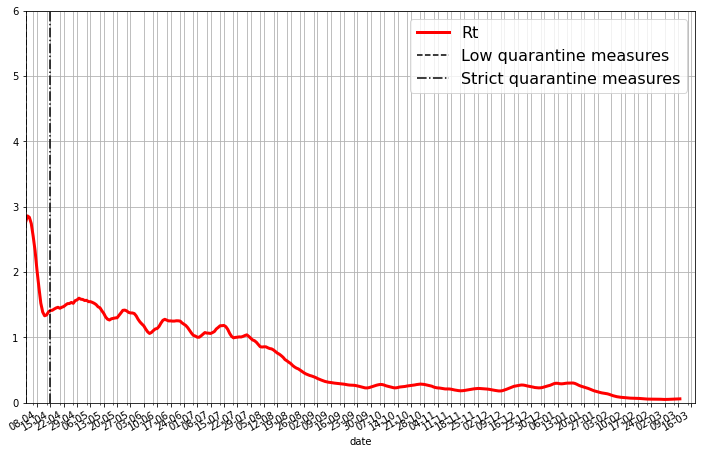

In [ ]:
import matplotlib.dates as mdates
ax = df.plot('date','Rt',linewidth=3,color='red',grid=True,ylim=(0,6),figsize=(12,8))
ax.axvline('2020-04-02', color='k', linestyle='--',label='Low quarantine measures')
ax.axvline('2020-04-15', color='k', linestyle='-.',label='Strict quarantine measures')
ax.xaxis.grid(True, which='minor')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gcf().autofmt_xdate()
plt.legend(fontsize=16)

In [ ]:
df

,date,Infected,Recovered,Deaths,Removed,Infected_Av,Recovered_Av,Deaths_Av,Removed_Av,Beta,Gamma,Rt
46,2020-04-02,1161,267,45,312,1.043667e+03,2.340000e+02,39.000000,2.730000e+02,0.091934,0.033333,2.758011
47,2020-04-03,1266,303,59,362,1.164000e+03,2.680000e+02,47.333333,3.153333e+02,0.095319,0.033333,2.859578
48,2020-04-04,1406,342,75,417,1.277667e+03,3.040000e+02,59.666667,3.636667e+02,0.094610,0.033333,2.838294
49,2020-04-05,1485,361,83,444,1.385667e+03,3.353333e+02,72.333333,4.076667e+02,0.091406,0.033333,2.742183
50,2020-04-06,1579,385,95,480,1.490000e+03,3.626667e+02,84.333333,4.470000e+02,0.084928,0.033333,2.547834
...,...,...,...,...,...,...,...,...,...,...,...,...
393,2021-03-15,2.30588e+06,2.20504e+06,70721,2.27576e+06,2.302703e+06,2.201424e+06,70580.666667,2.272005e+06,NaN,NaN,NaN
394,2021-03-16,2.3096e+06,2.20815e+06,70852,2.279e+06,2.306209e+06,2.204848e+06,70717.666667,2.275566e+06,NaN,NaN,NaN
395,2021-03-17,2.31415e+06,2.21154e+06,70998,2.28254e+06,2.309879e+06,2.208242e+06,70857.000000,2.279099e+06,NaN,NaN,NaN
396,2021-03-18,2.31929e+06,2.21606e+06,71121,2.28718e+06,2.314349e+06,2.211914e+06,70990.333333,2.282904e+06,NaN,NaN,NaN


In [ ]:
df_finalconRT= pd.merge(df_depcovid.set_index(["date"]),df.set_index(["date"]), how='outer', left_index=True, right_index=True)

In [ ]:
df_finalconRT.to_csv("Final complet.csv")

In [ ]:
df_finalconRT

,sub_region_1,place_id,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Recuperados,fallecidos,confirmados,Acum_Recuperados,Acum_fallecidos,Acum_confirmados,Infected,Recovered,Deaths,Removed,Infected_Av,Recovered_Av,Deaths_Av,Removed_Av,Beta,Gamma,Rt
date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-15,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,4.0,5.0,-5.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-16,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,0.0,5.0,-5.0,-1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-1.0,3.0,-4.0,6.0,15.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-18,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-3.0,1.0,-3.0,10.0,17.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-19,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-5.0,-5.0,-5.0,6.0,13.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-29.0,7.0,-32.0,-15.0,-16.0,10.0,3685.0,141.0,2740.0,2205041.0,70721.0,2305884.0,2.30588e+06,2.20504e+06,70721,2.27576e+06,2.302703e+06,2.201424e+06,70580.666667,2.272005e+06,NaN,NaN,NaN
2021-03-16,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-26.0,14.0,-26.0,-13.0,-15.0,10.0,3107.0,131.0,3716.0,2208148.0,70852.0,2309600.0,2.3096e+06,2.20815e+06,70852,2.279e+06,2.306209e+06,2.204848e+06,70717.666667,2.275566e+06,NaN,NaN,NaN
2021-03-17,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-28.0,9.0,-27.0,-16.0,-16.0,10.0,3389.0,146.0,4554.0,2211537.0,70998.0,2314154.0,2.31415e+06,2.21154e+06,70998,2.28254e+06,2.309879e+06,2.208242e+06,70857.000000,2.279099e+06,NaN,NaN,NaN


# Modulo SIR 

In [ ]:
df_en = pd.read_csv('Demanda.csv', delimiter=";", decimal=",") #Datos de Google
df_en.rename(columns={"Demanda Comercial kWh":'kwh'}, inplace=True)
df_en.rename(columns={"Fecha":'date'}, inplace=True)

In [ ]:
df_enernac= pd.pivot_table(df_en,values="kwh", index=['date'],columns=['CIIU'],aggfunc=np.sum)
df_enernac.reset_index(inplace=True)

In [ ]:
df_enernac['date']=pd.to_datetime(df_enernac['date'], format= "%Y/%m/%")


In [ ]:
df_final= pd.merge(df_enecol,df_finalconRT, how='outer', left_index=True, right_index=True)

In [ ]:
df_enecol=df_enernac.set_index(["date"])

In [ ]:
df_final.to_csv("Final completo3.csv")

In [ ]:
df_final

,index,"ACTIVIDADES ARTÍSTICAS, DE ENTRETENEMIENTO Y RECREACIÓN",ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y DE ASISTENCIA SOCIAL,ACTIVIDADES DE ORGANIZACIONES Y ENTIDADES EXTRATERRITORIALES,ACTIVIDADES DE SERVICIOS ADMINISTRATIVOS Y DE APOYO,ACTIVIDADES FINANCIERAS Y DE SEGUROS,ACTIVIDADES INMOBILIARIAS,"ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNICAS",ADMINISTRACIÓN PÚBLICA Y DEFENSA; PLANES DE SEGURIDAD SOCIAL DE AFILIACIÓN OBLIGATORIA,"AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y PESCA",ALOJAMIENTO Y SERVICIOS DE COMIDA,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS,CONSTRUCCIÓN,"DISTRIBUCIÓN DE AGUA; EVACUACIÓN Y TRATAMIENTO DE AGUAS RESIDUALES, GESTIÓN DE DESECHOS Y ACTIVIDADES DE SANEAMIENTO AMBIENTAL",EDUCACIÓN,EXPLOTACIÓN DE MINAS Y CANTERAS,INDUSTRIAS MANUFACTURERAS,INFORMACIÓN Y COMUNICACIONES,OTRAS ACTIVIDADES DE SERVICIOS,"SUMINISTRO DE ELECTRICIDAD, GAS, VAPOR Y AIRE ACONDICIONADO",TRANSPORTE Y ALMACENAMIENTO,sub_region_1,place_id,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Recuperados,fallecidos,confirmados,Acum_Recuperados,Acum_fallecidos,Acum_confirmados,Infected,Recovered,Deaths,Removed,Infected_Av,Recovered_Av,Deaths_Av,Removed_Av,Beta,Gamma,Rt
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,172229.54,1157274.04,76517.06,121629.79,220083.98,566128.31,85748.17,3066484.72,1161782.15,862631.02,2604959.12,170867.83,1560236.15,307086.67,14549951.92,9229193.31,1033500.22,363999.23,1013739.30,1052931.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,1.0,228210.43,1340140.82,82140.18,229681.04,364318.75,895657.38,215529.58,3162731.63,2046808.14,863880.59,3591672.82,191949.96,1608292.56,363815.80,15466432.98,17257396.78,1120412.61,472897.87,1144444.45,1248815.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,2.0,238842.77,1373809.65,83625.46,270741.93,364202.47,937394.43,257187.73,3204871.44,2318826.60,902359.35,3744107.46,226884.96,1704594.19,373909.78,15939993.30,21772969.95,1130760.49,501367.66,1303846.33,1362846.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,3.0,235174.54,1277404.21,79904.16,235819.36,251701.60,868191.79,249978.25,3128322.76,2176525.72,913612.10,3646282.33,245640.14,1704134.10,338805.92,15264115.38,22179822.94,1099520.67,462260.99,1360258.73,1272486.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,4.0,218629.26,1196433.00,77935.00,180763.97,225648.96,631008.06,169138.92,3078195.27,1689910.20,870971.35,3265432.89,250140.72,1630360.81,305792.95,15077599.07,17971188.25,1059836.16,421238.53,1285069.42,1128666.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15,439.0,146300.11,1412239.53,76266.91,293131.76,316390.14,846554.95,268937.22,3068730.03,2258338.31,657113.82,3520493.97,260391.66,1917248.67,521746.29,15355542.85,28200752.94,1022462.94,584451.33,1078496.14,1226450.45,Nacional,ChIJo5QVrjqkFY4RQKPy7wSaDZo,-29.0,7.0,-32.0,-15.0,-16.0,10.0,3685.0,141.0,2740.0,2205041.0,70721.0,2305884.0,2.30588e+06,2.20504e+06,70721,2.27576e+06,2.302703e+06,2.201424e+06,70580.666667,2.272005e+06,NaN,NaN,NaN
2021-03-16,440.0,161377.90,1408744.49,77183.10,303426.44,314876.42,857512.37,268651.64,3071487.06,2312207.16,668869.75,3550473.65,265356.12,1903375.12,527626.72,15395503.06,29011440.98,1020417.44,603775.74,1138424.32,1265251.60,Naciona